In [1]:
import ee
import google.auth
import math
import numpy as np
import tensorflow as tf
import folium
import time
import geopandas
import pandas


2023-04-21 07:13:06.584185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# this is needed to Successfully save authorization token. from ee.Authenticate()
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
ee.Authenticate()


Successfully saved authorization token.


In [4]:
ee.Initialize()

In [5]:
# bands used for prediction
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'] # bands with <= 30 resolution

COUNTRY_GEOMETRY = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na', 'Ukraine'));
COUNTRY_LATLON = 50., 31

LABEL_DATA = ee.ImageCollection("ESA/WorldCover/v100").first() # ee.image
LABEL_DATA = LABEL_DATA.clip(COUNTRY_GEOMETRY)


In [6]:

igbp_palette = [
    '#419BDF',  # water
    '#397D49',  # Trees
    '#88B053',  # Grass
    '#7A87C6',  # Flooded vegetation
    '#E49635',  # crops
    '#DFC35A',  # shrub and scrub
    '#C4281B',  # built-up areas
    '#A59B8F',  # bare ground
    '#B39FE1',  # snow and ice
]

LABEL_NAMES = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]
map = folium.Map(location=COUNTRY_LATLON, zoom_start=13)
def get_label_image() -> ee.Image:
    # Remap the ESA classifications into the Dynamic World classifications
    fromValues = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
    toValues = [1, 5, 2, 4, 6, 7, 8, 0, 3, 3, 7]
    return (
        LABEL_DATA
        .select("Map")
        .remap(fromValues, toValues)
        .rename("landcover")
        .unmask(0)  # fill missing values with 0 (water)
        .byte()     # 9 classifications fit into an unsinged 8-bit integer
    )

image_labels = get_label_image()

vis_params = {
  "bands": ["landcover"],
  "max": len(LABEL_NAMES) - 1,
  "palette": igbp_palette,
}
mapid_labels = image_labels.getMapId(vis_params)

folium.TileLayer(
    tiles=mapid_labels['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='esa',
  ).add_to(map)


In [7]:
#map

In [8]:
def cloudmask_and_clip(image):
    opaqueClouds_mask = 1 << 10
    cirrusClouds_mask =1 << 11
    bit_mask =opaqueClouds_mask | cirrusClouds_mask
    qa = image.select('QA60')
    mask = qa.bitwiseAnd(bit_mask).eq(0)

    return image.clip(COUNTRY_GEOMETRY).updateMask(mask)
def get_image() -> ee.image:
    """
    Returns:
        ee.image: a cloud masked sentinel-2 image.
    """
    SURF_REF_SEN2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    default_value = 690.0
    image = SURF_REF_SEN2.map(cloudmask_and_clip).select(BANDS).filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)).median().unmask(default_value).float()
    return image

In [9]:
image = get_image()

In [10]:
vis_params = {
  "min": 0,
  "max": 3000,
  "bands": ["B4", "B3", "B2"],
}
map = folium.Map(location=COUNTRY_LATLON, zoom_start=13)
image=image.clip(COUNTRY_GEOMETRY)
mapid = image.getMapId(vis_params)

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
folium.LayerControl().add_to(map)


In [11]:
map

In [11]:
shapeFile = geopandas.read_file("../data/validation_data/merged_harvest_validation_20220919.shp")
shapeFile.head()

,fid,cat,id,x,y,lat,lon,strata,set,rd_id,lab_set1,val_set1,com_set1,lab_set2,val_set2,com_set2,finHarvDat,geometry
0,249.0,249.0,248.0,-321360.0,639156.0,50.655048,25.458684,20.0,free_ukraine,51.0,Shabri,1.0,Harvested 11/08/22,Josef,1.0,Harvested 05/08-11/08/22,11/08/22,POINT (2834056.683 6560486.924)
1,165.0,165.0,164.0,447948.0,607452.0,50.294633,36.289471,20.0,free_ukraine,16.0,Shabri,0.0,Spring,Josef,0.0,NaN,NaN,POINT (4039734.283 6497444.336)
2,400.0,400.0,399.0,179688.0,655860.0,50.860849,32.548484,20.0,free_ukraine,32.0,Shabri,2.0,"Unclear, keeps greening up and browing down",Fangjie,1.0,Harvested 31/07/2022 and 29/08/2022,NaN,POINT (3623289.622 6596702.279)
3,387.0,387.0,386.0,115320.0,661740.0,50.928689,31.637558,20.0,free_ukraine,69.0,Shabri,0.0,Interesting,Fangjie,1.0,Harvested 17/07/2022,NaN,POINT (3521885.751 6608675.134)
4,306.0,306.0,305.0,543120.0,393504.0,48.307964,37.348245,20.0,free_ukraine,8.0,Shabri,1.0,Harvested 23/07/22,Blake,0.0,NaN,23/07/22,POINT (4157596.478 6158229.471)


In [12]:
lons_lats_np = np.array(shapeFile[['lon', 'lat']].dropna())
print(lons_lats_np.shape)

(558, 2)


In [13]:
points_from_sph_df = shapeFile[['lat', 'lon', 'val_set1', 'finHarvDat']].dropna(subset=['lat', 'lon', 'val_set1'])
points_from_sph_df['is_harvested'] = points_from_sph_df['val_set1'].apply(lambda x: x == 1)
points_from_sph_df = points_from_sph_df.drop(['val_set1'], axis=1)
points_from_sph_df.finHarvDat = points_from_sph_df.finHarvDat.apply(lambda x: str(x))
points_from_sph_df['point_id'] = np.arange(0, points_from_sph_df.shape[0], 1, dtype=int)
print(points_from_sph_df.head(), points_from_sph_df.shape)

         lat        lon finHarvDat  is_harvested  point_id
0  50.655048  25.458684   11/08/22          True         0
1  50.294633  36.289471        nan         False         1
2  50.860849  32.548484        nan         False         2
3  50.928689  31.637558        nan         False         3
4  48.307964  37.348245   23/07/22          True         4 (558, 5)


In [14]:
def overlay_points(img: ee.Image, df:pandas.DataFrame, coordinate_col_names:(str, str)=('lon', 'lat')) -> ee.FeatureCollection:
  # Convert pandas dataframe to an ee.FeatureCollection
  def createFeature(row):
      lon = coordinate_col_names[0]
      lat = coordinate_col_names[1]
      geometry = ee.Geometry.Point([row[lon], row[lat]])
      #print(df.columns.values)
      dic = {}
      for col_name in df.columns.values:
        dic[col_name] = row[col_name]
        
      return ee.Feature(geometry, dic)

  features = points_from_sph_df.apply(createFeature, axis=1).tolist()
  fc = ee.FeatureCollection(features)


  # Overlay the points on the imagery to get training.
  overlayed_fc = img.sampleRegions(
    collection= fc,
    scale= 10 # maybe we should make this 10 instead
  )
  return overlayed_fc


def export_to_drive(fc: ee.FeatureCollection, file:str, folder:str="NASA_Harvest2"):

  # Export the ee.FeatureCollection as a .GeoJSON file.
  task = ee.batch.Export.table.toDrive(**{
    'collection': fc,
    'description':file,
    'fileFormat': 'GeoJSON',
    'folder': folder
  })
  task.start()


  print('----')
  print(f'Polling for file name= {file}...')
  while task.active():
    time.sleep(5)
  print(f'Wrote {file}.GeoJSON. Check {folder} folder in Drive.')
  print('----')

In [17]:
#%%script echo skipping
# comment out script above to run this cell

export_to_drive(overlay_points(image, points_from_sph_df), file='points_from_sph')

----
Polling for file name= points_from_sph...
Wrote points_from_sph.GeoJSON. Check NASA_Harvest2 folder in Drive.
----


In [27]:
fc = overlay_points(image, points_from_sph_df)
fc.toList(1).get(0).getInfo()


EEException: User memory limit exceeded.

In [33]:
def getCols(tableMetadata):
  print(tableMetadata.columns)


fc.first()

In [19]:
from datetime import datetime

def read_geojson(file:str, date_col_name='finHarvDat') -> pandas.DataFrame:
    """ expects the date column to have this format "dd/mm/yy", example: "14/07/22".
        if df has no date column, pass None
    """
    def to_datetime(string):
        if(string == 'nan' or not string):
            return None
        splitted = string.split('/')
        day = int(splitted[0])
        month = int(splitted[1])
        year = 2000 + int(splitted[2])
        datetime_object = datetime(year=year, month = month, day=day)#datetime.strptime(string, '%d-%m-%Y')
        return datetime_object
    
    df = geopandas.read_file(f"../data/{file}.geojson")
    
    if(date_col_name != None):
        df[date_col_name] = df[date_col_name].apply(to_datetime)
        
    return df

In [20]:
read_geojson(file='points_from_sph').head()

,id,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,finHarvDat,is_harvested,lat,lon,point_id,geometry
0,0_0,2125.0000,1305.6666,480.06250,747.6667,737.50000,1240.3334,2350.3333,2778.0000,2964.6667,3040.00,2022-08-11,True,50.655048,25.458684,0,MULTIPOINT EMPTY
1,1_0,1897.3334,1376.0000,480.76190,684.0000,619.87500,918.5000,1825.6666,2032.0000,2136.0000,2198.00,NaT,False,50.294633,36.289471,1,MULTIPOINT EMPTY
2,2_0,2331.5000,1453.8000,480.66666,669.6818,656.20000,1056.0000,2084.0000,2361.2083,2527.6000,2722.75,NaT,False,50.860849,32.548484,2,MULTIPOINT EMPTY
3,3_0,2236.2500,1666.7500,513.88635,666.8400,808.46155,1061.3636,1756.8572,1969.7500,2133.0000,2287.25,NaT,False,50.928689,31.637558,3,MULTIPOINT EMPTY
4,4_0,1975.0000,1479.4000,420.31033,608.4138,671.10530,856.6957,1469.1666,1622.6666,1748.0000,1799.00,2022-07-23,True,48.307964,37.348245,4,MULTIPOINT EMPTY


In [18]:
for [lon, lat] in np.array(training_df[['lon', 'lat']]):
    folium.Marker(location=[lat, lon], popup = str([lon, lat])).add_to(map)

In [19]:
folium.LayerControl().add_to(map)
map

## Create 3-week image collection from sentindel2 in 2020

reference: https://medium.com/@moraesd90/creating-monthly-ndvi-composites-sentinel-2-on-google-earth-engine-a5c2d49bc9ca

In [16]:
def get_image(s2_img_collection):
    def add_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        image = image.addBands(ndvi.toFloat())
        return image.toFloat()
    default_value = 1000.0
    image = s2_img_collection.map(cloudmask_and_clip).select(BANDS).filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)).median().unmask(default_value).float()
    image = add_ndvi(image)
    return image

In [17]:
DATE_START = ee.Date('2022-01-01')
DATE_END= ee.Date('2022-12-27')
SURF_REF_SEN2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(DATE_START, DATE_END)

# start_weeks.getInfo -> [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]
total_weeks = ee.Number(DATE_END.difference(DATE_START, 'week')).round().getInfo()
start_weeks = ee.List.sequence(1, total_weeks, 3)

def extract_subset(start_week):
    
    start = DATE_START.advance(start_week, 'week')
    end = start.advance(3, 'week').advance(-1, 'day')
    
    def getCollection():
        return SURF_REF_SEN2.filterDate(start, end)
    
    img_collection = getCollection()
    return get_image(img_collection)
    
    

# Map the extract_subset function over the list of start weeks to create a new image collection that contains the subsets of the original image collection
new_img_collection = ee.ImageCollection.fromImages(start_weeks.map(extract_subset))
num_of_images = new_img_collection.size().getInfo()
# Print the number of images in the new image collection
print('Number of images in the new image collection:', num_of_images)
images_list = new_img_collection.toList(num_of_images)




Number of images in the new image collection: 17


In [18]:
start_end_dates = []
start_weeks = ee.List.sequence(1, total_weeks, 3)

# record the dates into start_end_dates array
def eeDate_to_datetime(eeDate: ee.Date)->datetime:
    year = eeDate.get('year').getInfo()
    month = eeDate.get('month').getInfo()
    day = eeDate.get('day').getInfo()
    return datetime(year=year, month=month, day=day)

for idx in range(num_of_images):
    start_week = start_weeks.get(idx).getInfo()
    start = DATE_START.advance(start_week, 'week')
    end = start.advance(3, 'week').advance(-1, 'day')
    start_end_dates.append((eeDate_to_datetime(start), eeDate_to_datetime(end)))

In [19]:
start_end_dates[0], len(start_end_dates)

((datetime.datetime(2022, 1, 8, 0, 0), datetime.datetime(2022, 1, 28, 0, 0)),
 17)

In [20]:
file_names = [f'img{idx}_overlayed' for idx in range(num_of_images)]

In [21]:
%%script echo skipping

# for each image, overylay the points(aka export to drive)
for idx in range(num_of_images):
    currImg = ee.Image(images_list.get(idx))
    file = f'img{idx}_overlayed'
    export_to_drive(overlay_points(currImg, points_from_sph_df),file=file )    

skipping


#### download & move to 'data' folder.

In [51]:

# true if (is_harvested is true) and if (the finHarvDat is within start_date & end_date)
def get__is_within_period(row):
    def date_within_range(dateToCheck:datetime, startDate:datetime, endDate:datetime):
        """credit: https://stackoverflow.com/users/22656/jon-skeet"""
        return dateToCheck >= startDate and dateToCheck <= endDate
    return row['is_harvested'] and date_within_range(row['finHarvDat'], row['start_date'], row['end_date'])
    
#samples = ee.List([]) # containing images
samples = [None] * (num_of_images) # sample[0] is None

path_inside_data_folder='overlayed_3week_images/'

for idx in range(num_of_images):
    curr_img_df = read_geojson(file=path_inside_data_folder + file_names[idx])
    curr_img_df = curr_img_df.sort_values('point_id') # to make sure the points are aligned when we subtract ndvi values below
    # add time cols
    start, end = start_end_dates[idx]
    curr_img_df['start_date'] = np.tile(np.array([start]), curr_img_df.shape[0])
    curr_img_df['end_date'] = np.tile(np.array([end]), curr_img_df.shape[0])
    
    curr_img_df['is_within_period'] = curr_img_df.apply(get__is_within_period, axis=1)
    
    curr_img_df['image_idx'] = np.tile(np.array([str(idx - 1)]), curr_img_df.shape[0])
    curr_img_df.rename(columns = {'point_id':'point_idx'}, inplace = True)
    
    samples[idx] = curr_img_df

In [52]:
merged_samples = pandas.concat(samples, sort=False)
merged_samples = merged_samples.drop(['geometry', 'id', 'is_harvested'], axis=1)
merged_samples[BANDS] /= 10000 # # divide by 10000 bc the bands are scaled by 10000
                                #(according to https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2)
merged_samples.point_idx = merged_samples.point_idx.astype(str)
merged_samples.point_idx = merged_samples.point_idx.apply(lambda x: 'p' + x)
merged_samples.sample_idx = merged_samples.sample_idx.apply(lambda x: 's' + x)

merged_samples.shape

(8928, 20)

In [53]:
merged_samples.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,NDVI,finHarvDat,lat,lon,point_idx,start_date,end_date,is_within_period,sample_idx,NDVI_diff
0,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.000000,2022-08-11,50.655048,25.458684,p0,2022-01-29,2022-02-18,False,s0,0.000000
1,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.000000,NaT,50.294633,36.289471,p1,2022-01-29,2022-02-18,False,s0,0.000000
2,0.0603,0.0712,0.8832,0.8808,0.8952,0.9323,0.8933,0.8527,0.8808,0.8184,-0.008108,NaT,50.860849,32.548484,p2,2022-01-29,2022-02-18,False,s0,-0.008108
3,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.000000,NaT,50.928689,31.637558,p3,2022-01-29,2022-02-18,False,s0,0.000000
4,0.1662,0.1304,0.0392,0.0514,0.0719,0.0738,0.0820,0.0886,0.1092,0.0994,0.205964,2022-07-23,48.307964,37.348245,p4,2022-01-29,2022-02-18,False,s0,-0.050371


In [54]:
sum(merged_samples.is_within_period) # we expect 366

366

In [55]:
# convert pandas df to geopandas df
merged_samples_gdf = geopandas.GeoDataFrame(
    merged_samples, geometry=geopandas.points_from_xy(merged_samples.lon, merged_samples.lat))

# save dataset
merged_samples_gdf.to_file('../data/merged_samples_gdf.geojson', driver='GeoJSON')

In [ ]:
def normalize_arr(arr: np.ndarray):
    newArr = arr.copy()
    mean = newArr.mean(axis=0)
    # print(mean.shape) --> (12,)
    sd = newArr.std(axis=0)
    newArr -= mean
    newArr = newArr/sd
    return newArr

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X = np.concatenate((training_bands_np, testing_inputs[0]), axis=0)
Y = np.concatenate((training_labels_np, testing_labels[0]), axis=0)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [226]:
X = testing_inputs[0]
Y = tf.keras.utils.to_categorical(testing_labels[0], num_classes=9) # convert to one hot

X = normalize_arr(X)


In [227]:
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(9, activation='sigmoid'))
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 64)                832       
                                                                 
 dense_65 (Dense)            (None, 64)                4160      
                                                                 
 dense_66 (Dense)            (None, 32)                2080      
                                                                 
 dense_67 (Dense)            (None, 16)                528       
                                                                 
 dense_68 (Dense)            (None, 9)                 153       
                                                                 
Total params: 7,753
Trainable params: 7,753
Non-trainable params: 0
_________________________________________________________________


In [228]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['acc'])

In [229]:
model.fit(x=X, y=Y, epochs=50)

Epoch 1/50
16/16 [==============================] - 2s 11ms/step - loss: 0.6696 - acc: 0.1660
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.6041 - acc: 0.0156
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 0.5213 - acc: 0.0059
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.3952 - acc: 0.4844
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.1987 - acc: 0.8516
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0912 - acc: 0.8770
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0744 - acc: 0.9023
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0658 - acc: 0.9004
Epoch 9/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0602 - acc: 0.9082
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0561 - acc: 0.9082
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - l

In [235]:
print(model.predict(normalize_arr(training_bands_np)) [:10])

18/18 [==============================] - 0s 2ms/step
[[2.0797403e-14 1.0000000e+00 4.9819439e-14 4.4149458e-25 5.8256776e-12
  4.5273704e-19 1.8602814e-22 2.4151072e-09 2.5884039e-24]
 [2.9026800e-10 9.9999958e-01 2.6395182e-07 2.4958341e-12 3.4008187e-07
  7.0598652e-11 2.9310042e-13 2.3604119e-03 2.7550719e-14]
 [2.5544153e-07 9.9999595e-01 2.0656380e-07 8.8471954e-13 1.0616707e-06
  4.1908516e-10 8.8713125e-12 2.9404740e-05 5.7713930e-13]
 [9.9393779e-01 5.1253702e-02 1.1226284e-05 3.6245535e-07 5.8129245e-07
  9.6997137e-06 1.3749387e-07 1.2412373e-05 4.3833548e-10]
 [7.6507814e-03 8.4809321e-01 3.4071780e-07 3.5466560e-10 1.1341422e-09
  9.0489731e-09 4.8485040e-12 2.0962590e-04 1.3684637e-14]
 [7.6711600e-05 7.1283840e-03 1.4468260e-01 7.8506283e-03 9.0890253e-01
  1.4205954e-04 2.0561689e-01 9.8649738e-04 3.7409904e-05]
 [8.8222514e-06 9.9991500e-01 7.8990579e-06 7.8696510e-10 2.0745663e-05
  5.6265197e-08 3.9822261e-09 5.1350816e-04 4.0986536e-10]
 [9.2425847e-01 5.4556226e-06 

In [220]:
testing_inputs[1]

array([[1315., 1109.,  976., ...,  737., 2390., 1705.],
       [1318., 1120.,  999., ...,  724., 2490., 1794.],
       [1318., 1106., 1009., ...,  724., 2490., 1794.],
       ...,
       [1297.,  980.,  806., ...,  498., 1072.,  594.],
       [1297.,  980.,  812., ...,  498., 1403.,  754.],
       [1297.,  993.,  851., ...,  498., 1772., 1080.]], dtype=float32)

In [192]:
a = tf.keras.utils.to_categorical(Y, num_classes=9)


In [193]:
np.unique(Y)

array([0, 1, 2, 3, 4, 6, 7], dtype=uint8)

In [194]:
a.shape

(512, 9)

In [195]:
a.sum(axis=0)

array([286., 159.,   8.,  36.,  20.,   0.,   2.,   1.,   0.],
      dtype=float32)

In [221]:
training_bands_np

array([[-0.46908981, -0.69322336, -0.71213709, ...,  3.25017837,
        -1.00524363, -1.94793795],
       [-2.07328656, -1.86576377, -0.53572238, ..., -0.28971328,
        -0.6863655 , -1.26923221],
       [-0.14530698, -0.47405693, -0.94188649, ...,  1.00853549,
        -0.37313122, -0.98423457],
       ...,
       [-0.3955028 , -0.53432769,  0.25609249, ...,  0.73157576,
        -1.09836733, -0.5126663 ],
       [-0.99891626, -1.02745217, -0.74495843, ...,  0.22093124,
         0.82054532, -0.53029502],
       [ 0.03620862, -0.31077793, -0.50700371, ..., -1.38240599,
        -0.10575332,  0.44281035]])

In [239]:
np.unique(training_labels_np)

array([0, 1, 2, 4, 7])

In [255]:
onehot = tf.keras.utils.to_categorical(training_labels_np, num_classes=9).astype(int)# convert to one hot
sums = onehot.sum(axis=0)

print(list(sums))
print(LABEL_NAMES)

[2, 3, 11, 0, 541, 0, 0, 1, 0]
['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']


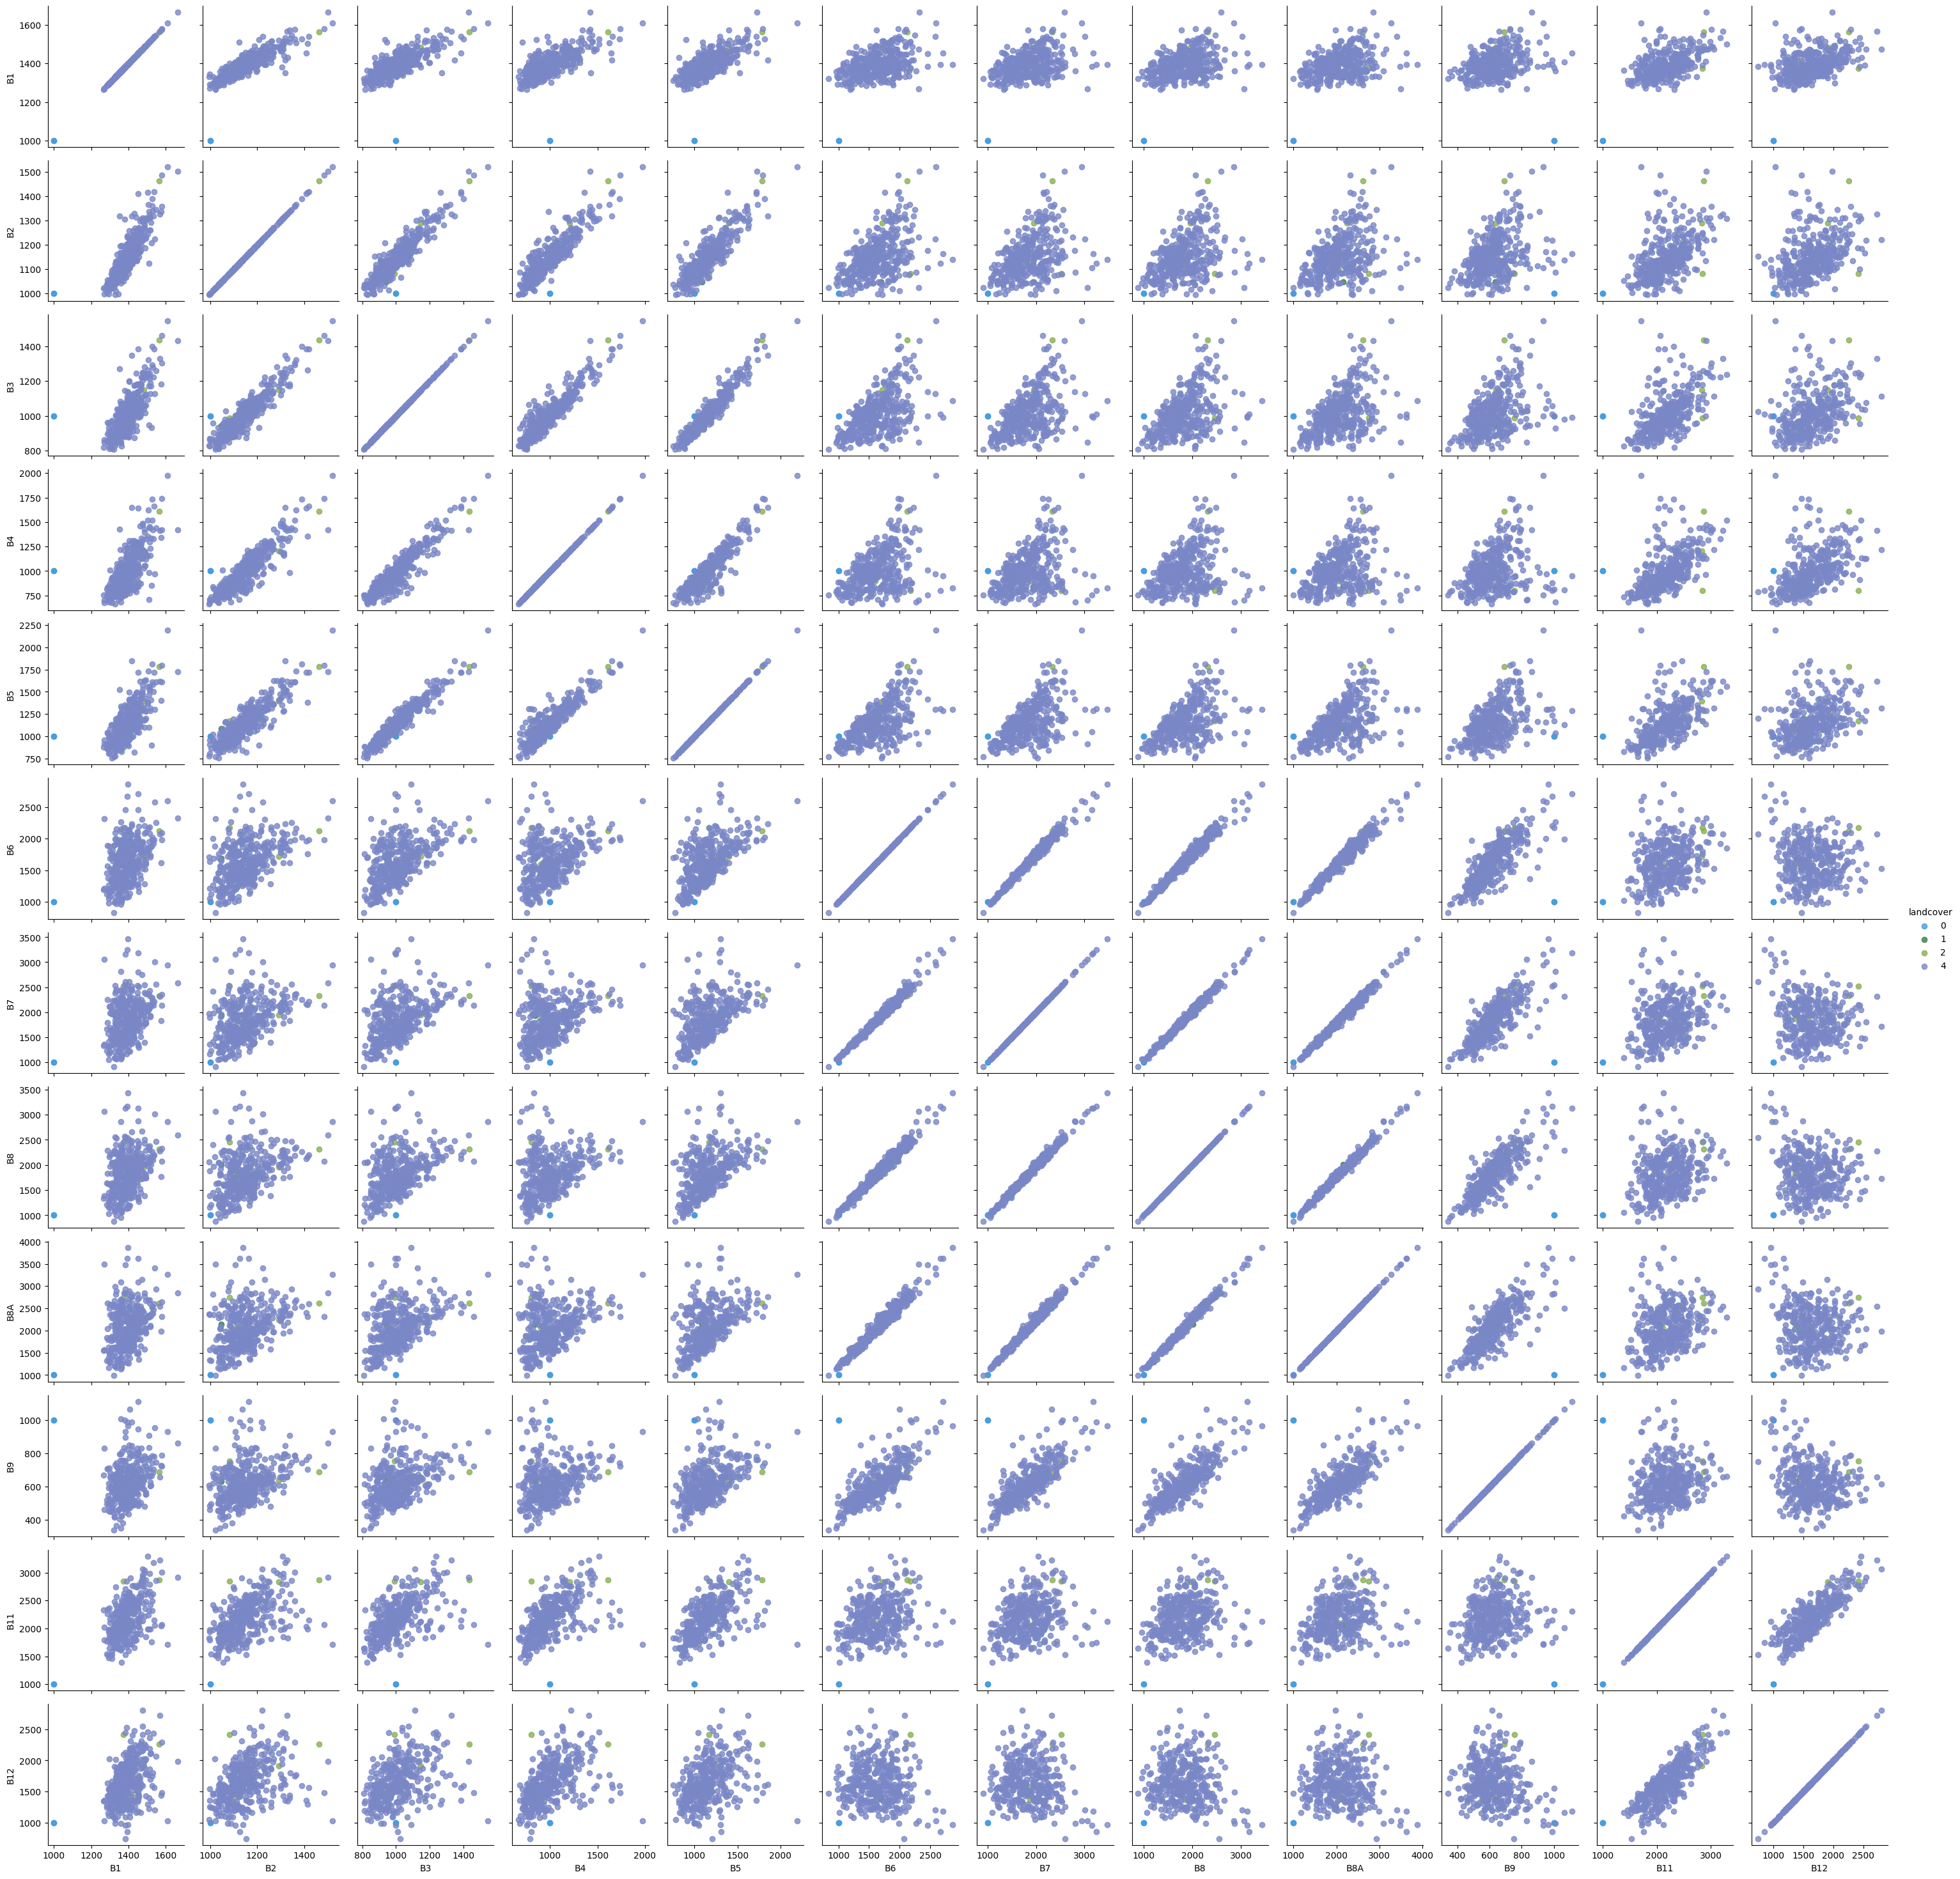

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

data= training_df

g = sns.PairGrid(data, vars=BANDS,
                 hue='landcover', palette=igbp_palette)
g.map(plt.scatter, alpha=0.8)
g.add_legend();

In [263]:
g = sns.PairGrid(iris, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

,id,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,landcover,geometry
0,0_0,1361.0,1839.0,985.5,1088.5,928.0,682.0,1037.5,2267.5,2811.0,2859.0,3090.0,1009.0,4,MULTIPOINT EMPTY
1,1_0,1252.0,1952.0,1216.5,981.5,949.5,717.5,1072.0,1602.5,1834.0,1902.0,2177.0,600.0,4,MULTIPOINT EMPTY
2,2_0,1383.0,2063.0,1313.5,1108.5,900.0,932.0,1050.0,1942.0,2300.0,2385.0,2777.0,750.0,4,MULTIPOINT EMPTY
3,3_0,1404.0,1826.0,1292.0,1144.0,945.0,867.0,1086.0,1709.0,1991.0,1966.0,2248.0,616.0,4,MULTIPOINT EMPTY
4,4_0,1291.0,1521.0,1153.5,1025.0,850.5,773.0,850.0,1372.5,1576.5,1623.5,1796.5,548.0,4,MULTIPOINT EMPTY
